# 变量设置

In [213]:
# 设置数据集名称
dataset_name = ['LUAD', 'LUSC']
# 设置俩： ['LUAD', 'LUSC']
# 单一个： ['LUAD'] 
method = 'normal' # diff是上面俩数据集的差异，normal是和正常样本的差异
# method = 'diff'

# 数据导入

## 库

In [214]:
import requests
import os
import gzip
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
from scikit-learn import datasets
import warnings
import GEOparse
from typing import Tuple, List
from scikit-learn.metrics import  roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,fbeta_score
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
from multiprocessing import Pool, cpu_count
import ast
from scikit-learn.model_selection import train_test_split
from scikit-learn.feature_selection import SelectKBest
from scikit-learn.feature_selection import chi2
from scikit-learn.feature_selection import f_classif
from scikit-learn.feature_selection import mutual_info_classif
from scikit-learn.linear_model import LinearRegression, RidgeClassifier, Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, ElasticNet,ElasticNetCV,SGDClassifier,RidgeClassifierCV
from scikit-learn.svm import SVC, LinearSVC, NuSVC
warnings.filterwarnings('ignore')

In [215]:
def download_and_parse_data(dataset_name):
    pkl_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna_transposed.pkl'
    if os.path.exists(pkl_file_path):
        df_t = pd.read_pickle(pkl_file_path)
    else:
        url = "https://gdc-hub.s3.us-east-1.amazonaws.com/download/TCGA-" + dataset_name + ".mirna.tsv.gz"
        response = requests.get(url)
        os.makedirs('./datasets', exist_ok=True)
        gz_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv.gz'
        with open(gz_file_path, 'wb') as f_out:
            f_out.write(response.content)
        tsv_file_path = './datasets/' + 'TCGA-' + dataset_name + '.mirna.tsv'
        with gzip.open(gz_file_path, 'rb') as f_in:
            with open(tsv_file_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        df = pd.read_csv(tsv_file_path, sep='\t')
        df_t = df.transpose()
        df_t.columns = df_t.iloc[0]
        df_t = df_t.drop(df_t.index[0])
        df_t = np.power(2, df_t) - 1
        df_t = df_t.round(4)
        df_t['Status'] = df_t.index.map(lambda x: 1 if x.split('-')[3][:2] == '01' else 0)
        df_t = df_t[['Status'] + [col for col in df_t.columns if col != 'Status']]
        df_t.to_pickle(pkl_file_path)
        os.remove(gz_file_path)
        os.remove(tsv_file_path)
    df_t = df_t.apply(pd.to_numeric)
    return df_t

def find_healthy_samples(df):
    healthy_samples_df = df[df['Status'] == 0]
    return healthy_samples_df

In [216]:
if method == "diff":
    dataA = download_and_parse_data(dataset_name[0])
    dataB = download_and_parse_data(dataset_name[1])

    A_up = dataA[dataA['Status'] == 1]
    B_up = dataB[dataB['Status'] == 1]

    B_up['Status'] = 0
    df_transposed = pd.concat([A_up, B_up], ignore_index=True)
elif method == "normal":
    df_transposed = pd.DataFrame()
    for name in dataset_name:
        df_transposed = df_transposed.append(download_and_parse_data(name))
train_data = df_transposed.apply(pd.to_numeric)

## 函数 准备

#### 定义存储结果的DataFrame

In [217]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','intercept', 'miRNA_ID'])

#### 可接受的权重的范围筛选器

In [218]:
def get_allowed_numbers(max_n=25,allowed_factors=[1,2,3,4,5]):
    result = []
    for x in allowed_factors:
        for y in allowed_factors:
            result.append(x*y)
        result.append(x)
    result = list(set(result))
    return result

def is_all_in_list(list,n=25,allowed_factors=[2,3,5]):
    for i in list:
        if i not in get_allowed_numbers(n,allowed_factors):
            return False
    return list

### 画图

分数分布图

In [219]:
plot_labels = ['得了', '没得']

In [220]:
def plot_score_distribution(ax, y_score, final_Status):                                 # 这个函数负责处理分数分布图这一个小图
    ax.scatter(range(len(y_score)), y_score, c=final_Status, cmap='bwr', alpha=0.5)     # 画散点图，x轴是样本序号，y轴是分数，颜色是感染情况，颜色映射是蓝白红，透明度是0.5
                                                                                        # x是样本序号：分开画，免得都黏在一起了，透明度的设置是一样的原因。
    ax.set_title('分数分布图')
    ax.set_xlabel('样本序号')
    ax.set_ylabel('分数')
    plt.rcParams['font.sans-serif']=['SimHei']                                          # 中文乱码
    plt.rcParams['axes.unicode_minus']=False                                            # 负号乱码
    labels = plot_labels                                                                # 图例标签，这里是感染情况，以后如果换了的话得改。 #todo 将这个改为传入参数
    ax.legend(labels, loc='upper right')                                                # 图例
    ax.plot([0, len(y_score)], [0.5, 0.5], color='black', lw=1, linestyle='--')         # 以0.5为界，画一条虚线，表示分数大于0.5的是细菌感染，小于0.5的是病毒感染，这个以后也得改
                                                                                        # 因为不同的模型（如linear regression 和 ridge regression）的判断标准不一样，所以这个界限也不一样。
                                                                                        # 现在的做法是直接在y_score 上做手脚，还是……蛮不优雅的，但是先这样吧。
                                                                                        # todo 将这个改为传入参数

ROC曲线

In [221]:
def plot_roc_curve(ax, y_score, final_Status):
    from scikit-learn.metrics import auc
    fpr, tpr, thresholds = roc_curve(final_Status, y_score)
    roc_auc = auc(fpr, tpr)
    ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlabel('False Positive Rate 假阳性率')
    ax.set_ylabel('True Positive Rate 真阳性率')
    ax.set_title('ROC 曲线（受试者工作特征曲线）')
    ax.legend(loc="lower right")

PR曲线

In [222]:
def plot_pr_curve(ax, y_score, final_Status):
    precision, recall, thresholds = precision_recall_curve(final_Status, y_score)
    ax.plot(recall, precision, color='darkorange', lw=2, label='PR curve')
    ax.set_xlabel('Recall 召回率')
    ax.set_ylabel('Precision 准确率')
    ax.set_title('PR 曲线（准确率-召回率曲线）')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.legend(loc="lower left")

混淆矩阵

In [223]:
def plot_confusion_matrix(ax, y_score, final_Status):
    y_pred = np.where(y_score > 0.5, 1, 0)
    cnf_matrix = confusion_matrix(final_Status, y_pred)
    ax.imshow(cnf_matrix, interpolation='nearest',cmap=plt.cm.Blues) # type: ignore
    ax.set_title('Confusion Matrix 混淆矩阵')
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, plot_labels, rotation=45)
    plt.yticks(tick_marks, plot_labels)
    thresh = cnf_matrix.max() / 2.
    for i in range(cnf_matrix.shape[0]):
        for j in range(cnf_matrix.shape[1]):
            plt.text(j, i, cnf_matrix[i, j],horizontalalignment="center",color="white" if cnf_matrix[i, j] > thresh else "black",fontsize=20)
    plt.tight_layout()
    plt.ylabel('True label 感染情况')
    plt.xlabel('Predicted label 预测情况')

分数分布图、ROC曲线、PR曲线和混淆矩阵

In [224]:
def plot_all(score, Status, title="分数分布图、ROC曲线、PR曲线和混淆矩阵", feature=None, weight=None):
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))                                                     # 规定画布大小为1200*1200px，分成2*2的4个小图
    fig.suptitle(title, fontsize=16)                                                                    # 设置标题
    plot_score_distribution(axs[0,0], score, Status)                                                    # 第一个小图（左上角）是分数分布图 这里的axs[0,0]是指第一行第一列的小图，注意计数是从0开始的。
    plot_roc_curve(axs[0,1], score, Status)                                                             # 第二个小图（右上角）是ROC曲线
    plot_pr_curve(axs[1,0], score, Status)                                                              # 第三个小图（左下角）是PR曲线
    plot_confusion_matrix(axs[1,1], score, Status)                                                      # 第四个小图（右下角）是混淆矩阵
    if feature or weight:                                                                               # 如果有feature或者weight的话，就在图的下方加上文字
        try:
            # add margin at bottom
            fig.subplots_adjust(bottom=0.12)                                                            # 调整图的下边距，这样文字就不会挡住图了
            # add feature and weight at the bottom
            fig.text(0.5, 0.04, '使用feature:'+str(feature), ha='center', va='bottom', fontsize=12)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
            fig.text(0.5, 0.02, '对应权重:'+str(weight), ha='center', va='bottom', fontsize=8)          # 同上
        except:
            pass                                                                                        # 如果出错了就算了
    return fig, axs

##### 给定 基因 权重 和数据，计算分数并画图（可能需要修改）

### 筛选

筛选哪些基因比较有差异

In [225]:
def get_higher_columns(data, diff=2.0):
    data_mean = data.groupby('Status').mean()
    higher_columns = []
    higher_times = []
    for i in range(data_mean.shape[1]):
        if  diff*data_mean.iloc[0,i] < data_mean.iloc[1,i]  or data_mean.iloc[0,i] > diff*data_mean.iloc[1,i]:
            higher_columns.append(data_mean.columns[i])
            # 0
            if data_mean.iloc[0,i] == 0:
                higher_times.append(1e10)
            else:
                higher_times.append(data_mean.iloc[1,i]/data_mean.iloc[0,i])
    return higher_columns, higher_times

排序有差异的基因

In [226]:
def sort_higher_columns(data, higher_columns, higher_times):
    # sort the columns and times together
    data_higher_times, data_higher_columns = zip(*sorted(zip(higher_times, higher_columns), reverse=True))
    # convert data_higher_columns to list
    data_higher_columns = list(data_higher_columns)
    # add Status column to the top of data_higher_columns
    data_higher_columns.append('Status')
    # get the new data
    data_higher = data[data_higher_columns]
    return data_higher, data_higher_times

输出

In [227]:
def print_best_acc(test_acc, n, gene_symbol, coef):
    best_acc = max(test_acc)
    best_i = 0
    i = 0
    print('最好的准确率为：', best_acc)
    for acc in test_acc:
        if acc == best_acc:
            print('='*60)
            print('对应的特征数为：', n[i],'方法为：', methods[i // len(models)].__name__,'特征为：', gene_symbol[i])
            print('模型为：', models[i % len(models)],'特征权重为：', coef[i])
            weights_avg = np.mean(coef[i])
            new_coefs = []
            for j in range(len(coef[i])):
                # new_coefs.append(10*(coef[i][j]/weights_avg)) 保留2位小数
                # new_coefs.append(round(10*(coef[i][j]/weights_avg), 2)) type numpy.ndarray doesn't define __round__ method
                new_coefs.append(np.round(10*(coef[i][j]/weights_avg), 2))
            print('比例大致为：', new_coefs)
        i += 1

一次性完成基因筛选和模型训练
通过调控C，使用LogisticRegression or LinearSVC 一次性完成基因筛选和模型训练

In [228]:
def evaluate_classifier(clf, method, model, X_train, y_train, X_test, y_test, params):
    global final_results

    acc_scores, auc_scores, f1_scores, precision_scores, recall_scores, n_features = [], [], [], [], [], []

    for param in params:
        clf.set_params(**param)
        clf.fit(X_train, y_train)
        nonzero_coef_indices = np.flatnonzero(clf.coef_)  # Indices where coef_ != 0
        n = len(nonzero_coef_indices)
        y_pred = clf.predict(X_test)
        y_pred = np.array([1 if i > 0.5 else 0 for i in y_pred], dtype=int)
        
        if 3 <= n <= 20:
            cm = confusion_matrix(y_test, y_pred)
            auc = roc_auc_score(y_test, y_pred)
            f1 = f1_score(y_test, y_pred)
            f2 = fbeta_score(y_test, y_pred, beta=2)
            f05 = fbeta_score(y_test, y_pred, beta=0.5)
            precision = precision_score(y_test, y_pred)
            recall = recall_score(y_test, y_pred)
            
            # acc = clf.score(X_test, y_test) if method is lasso or elasticnet, score is not accuracy
            acc = accuracy_score(y_test, y_pred)

            allowed_numbers = get_allowed_numbers()
            coef = clf.coef_
            # only use non-zero coef
            coef = coef[coef != 0]
            weights_avg = np.mean(np.abs(coef))
            min_times = 0.5 / np.min(np.abs(coef))
            max_times = 25.5 / np.max(np.abs(coef))
            if min_times > max_times:
                multipletimes = [max_times]
            else:
                multipletimes = np.linspace(min_times, max_times, num=500)
            found_coef = False
            coef_roundeds = []
            deltas = []
            for multipletime in multipletimes:
                coef_rounded_t = []
                differences = []
                for coef_i in coef:
                    # 符号问题，先存符号
                    coef_i_sign = coef_i / np.abs(coef_i)
                    coef_i = np.abs(coef_i)
                    differences_i = []
                    for allowed_number in allowed_numbers:
                        difference = np.abs(coef_i * multipletime - allowed_number) / allowed_number
                        differences_i.append(difference)
                    best_allowed_number = allowed_numbers[np.argmin(differences_i)]
                    coef_rounded_t.append(best_allowed_number * coef_i_sign)
                    differences.append(np.min(differences_i))
                delta = np.average(np.array(differences))
                deltas.append(delta)
                coef_roundeds.append(coef_rounded_t)

            coef_rounded = coef_roundeds[np.argmin(deltas)]
            delta = np.min(deltas)
            mean_coef = np.mean(np.abs(coef_rounded))
            times = mean_coef / weights_avg
            if delta < 0.30: # 30%的平均误差
                found_coef = True
            if np.sum(coef_rounded) == 0:
                balanced = True
            else:
                balanced = False

            intercept = clf.intercept_

            nonzero_coef_indices = np.flatnonzero(clf.coef_) # get the indices of non-zero coef
            gene_id = list(X_train.columns[nonzero_coef_indices])

            result = pd.DataFrame({
                'method': [method],
                'model': [model],
                'n': [n],
                'acc': [acc],
                'auc': [auc],
                'f1': [f1],
                'f2': [f2],
                'f05': [f05],
                'precision': [precision],
                'recall': [recall],
                'confusionmatrix': [cm],
                'coef': [coef.tolist()],
                'coef_rounded': [coef_rounded],
                'found_coef': [found_coef],
                'delta': [delta],
                'multiple_times': [times],
                'intercept': [intercept.item()],
                'balanced': [balanced],
                'gene_id': [gene_id],
            })

            final_results = pd.concat([final_results, result], ignore_index=True) 

            # For plotting
            n_features.append(n) 
            acc_scores.append(acc)
            auc_scores.append(auc)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)
        if n > 22:
            break

    # Plotting inside the function
    plt.figure(figsize=(10,6))
    plt.plot(n_features, auc_scores, label='AUC')
    plt.scatter(n_features, auc_scores)
    plt.plot(n_features, f1_scores, label='F1 score')
    plt.scatter(n_features, f1_scores)
    plt.plot(n_features, precision_scores, label='Precision', linestyle='dashed')
    plt.plot(n_features, recall_scores, label='Recall', linestyle='dashed')
    plt.title('Performance metrics by number of features (' + method + ')')
    plt.xlabel('Number of features')
    plt.ylabel('Performance metrics')
    plt.legend()
    plt.grid()
    plt.show()

## 训练

In [229]:
higher_columns, higher_times = get_higher_columns(train_data, 2)
print('高表达差异基因数目：', len(higher_columns))

高表达差异基因数目： 1009


根据倍率不同进行排序

In [230]:
data_higher, data_higher_times = sort_higher_columns(train_data, higher_columns, higher_times)
X_train, X_test, y_train, y_test = train_test_split(data_higher.drop(['Status'], axis=1), data_higher['Status'], test_size=0.2, random_state=42)
# X_train, y_train = sm.fit_resample(data_higher, data_higher['Status'])
# smote
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)
# X_test, y_test= sm.fit_resample(X_test, y_test)

### 训练不同的模型，使用不同的特征选择方法，选择出特征后，使用不同的方法来训练模型

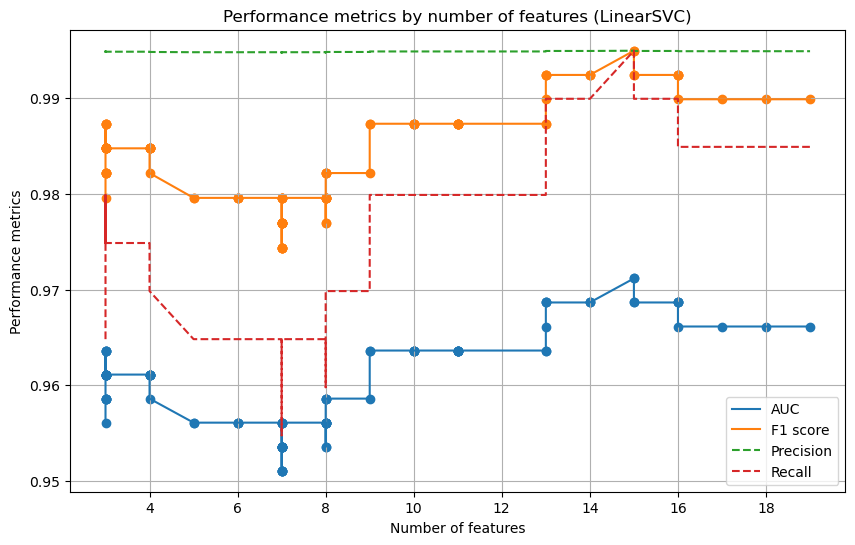

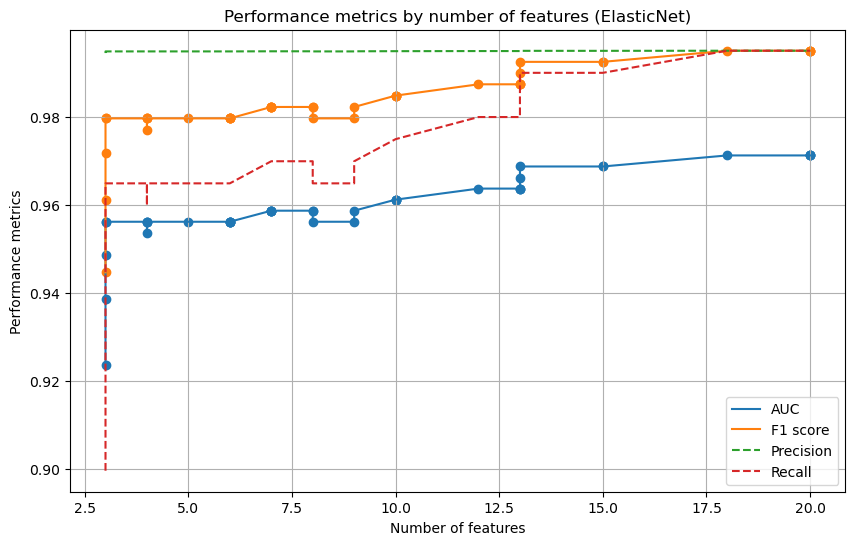

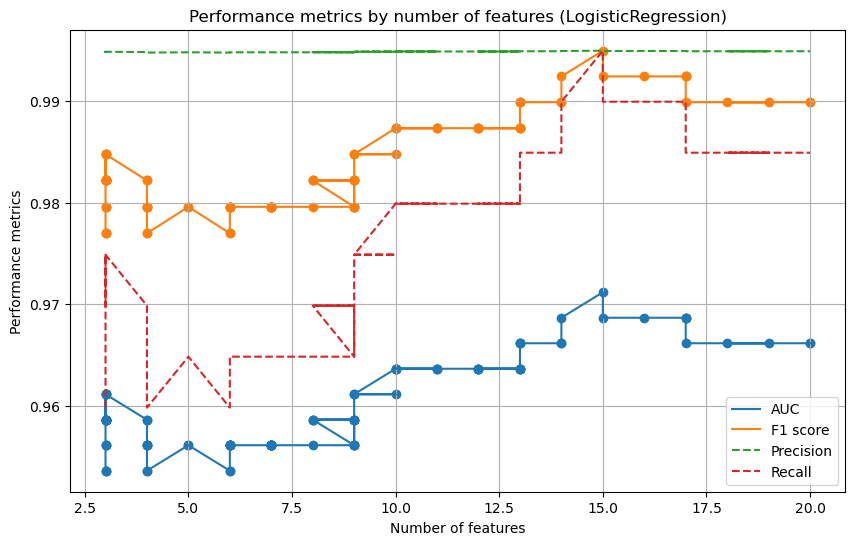

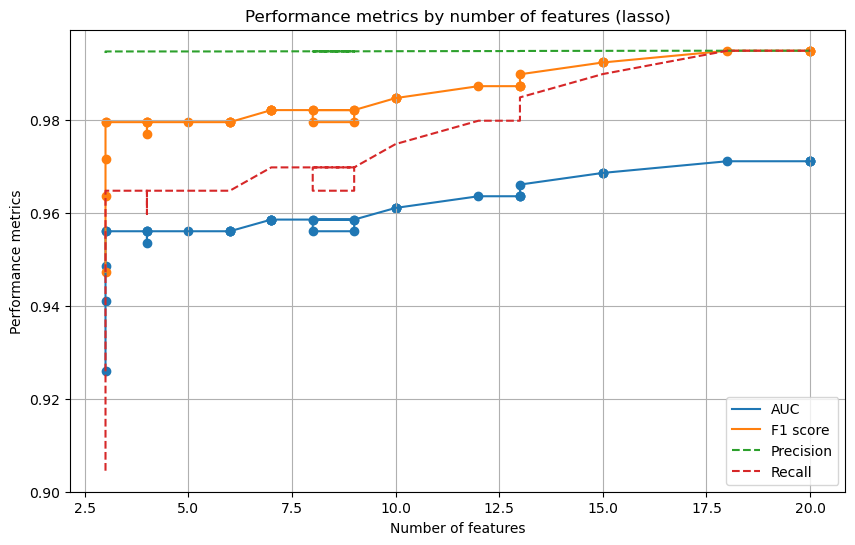

In [231]:
final_results = pd.DataFrame(columns=['method', 'model', 'n', 'acc', 'auc', 'f1', 'precision', 'recall', 'f2','f05', 'confusionmatrix','coef', 'coef_rounded', 'found_coef', 'multiple_times','delta','intercept','balanced', 'gene_id'])
max_run_num = 300
C_values = np.logspace(-9, 0, num=max_run_num, base=10)
alpha_values = np.logspace(15, -5, num=max_run_num, base=10)

# LinearSVC
lsvc = LinearSVC(penalty="l1", dual=False)
lsvc_params = [{'C': C} for C in C_values]
evaluate_classifier(lsvc, 'LinearSVC', 'lsvc', X_train, y_train, X_test, y_test, lsvc_params)
# Elastic-Net
#    encv = ElasticNetCV(l1_ratio=1-np.logspace(-3, -0.1, num=10, base=10), n_alphas=200, max_iter=5000, n_jobs=10, selection='cyclic')
#    encv.fit(X_train, y_train)
#    print('-'*60)
#    print('ElasticNetCV')
#    print('best l1_ratio:', encv.l1_ratio_)
#    print('selected features:', X_train.columns[encv.coef_ != 0].values)
#    print('n features:', encv.n_features_in_)
en = ElasticNet(alpha=0.1, l1_ratio=0.75, max_iter=5000, selection='cyclic')
en_params = [{'alpha': alpha} for alpha in alpha_values]
evaluate_classifier(en, 'ElasticNet', 'en', X_train, y_train, X_test, y_test, en_params)
# LogisticRegression
#       lrcv = LogisticRegressionCV(penalty='l1', solver='liblinear', max_iter=10000, n_jobs=-1)
#       lrcv.fit(X_train, y_train)
#       print('-'*60)
#       print('LogisticRegressionCV')
#       print('best C:', lrcv.C_)
# print('selected features:', X_train.columns[lrcv.coef_ != 0].values)
# print('n features:', lrcv.n_features_in_)
lr = LogisticRegression(penalty='l1', solver='liblinear')
lr_params = [{'C': C} for C in C_values]
evaluate_classifier(lr, 'LogisticRegression', 'lr', X_train, y_train, X_test, y_test, lr_params)
# Lasso
#       lassocv = LassoCV(max_iter=5000, n_jobs=-1)
#       lassocv.fit(X_train, y_train)
#       print('-'*60)
#       print('LassoCV')
#       print('best alpha:', lassocv.alpha_)
#       print('selected features:', X_train.columns[lassocv.coef_ != 0].values)
#       print('n features:', lassocv.n_features_in_)
lasso = Lasso(alpha=0.1, max_iter=5000)
lasso_params = [{'alpha': alpha} for alpha in alpha_values]
evaluate_classifier(lasso, 'lasso', 'lasso', X_train, y_train, X_test, y_test, lasso_params)


In [232]:
# 重新排序
sort_columns = ['found_coef','f1', 'auc',  'balanced','n', 'delta']
sort_order = [False,False, False, False,True, True]

# Sort the DataFrame
results_sorted = final_results.sort_values(by=sort_columns, ascending=sort_order).reset_index(drop=True).copy()
results_sorted_view = results_sorted.head(5).copy().drop(['coef','gene_id','intercept','multiple_times'], axis=1)
# results_sorted_view

# 复制 'final_results' 到 'final_results_unique' 
final_results_unique = results_sorted.copy()

# 将 'coef_rounded' 和 'gene_id' 列转化为字符串
final_results_unique['coef_rounded'] = final_results_unique['coef_rounded'].astype('str')
final_results_unique['gene_id'] = final_results_unique['gene_id'].astype('str')

# 删除重复行
final_results_unique.drop_duplicates(subset=['coef_rounded', 'gene_id'], keep='first', inplace=True)
final_results_unique['coef_rounded'] = final_results_unique['coef_rounded'].apply(ast.literal_eval)
final_results_unique['gene_id'] = final_results_unique['gene_id'].apply(ast.literal_eval)

In [233]:
# reproduce
results_sorted_found_coef = final_results_unique[results_sorted['found_coef'] == True].reset_index(drop=True).copy()
reperduce = []
for i in range(len(results_sorted_found_coef)):
    gene_ids = results_sorted_found_coef['gene_id'][i]
    # check if gene_ids are in X_test columns
    if set(gene_ids).issubset(set(X_test.columns)):
        X_test_selected = X_test[gene_ids].copy()
    else:
        # modify gene_ids to match X_test columns
        gene_ids = [col for col in gene_ids if col in X_test.columns]
        X_test_selected = X_test[gene_ids].copy()
    y_test_selected = y_test
    # calculate score
    coef = results_sorted_found_coef['coef_rounded'][i]
    times = results_sorted_found_coef['multiple_times'][i]
    intercept = results_sorted_found_coef['intercept'][i]
    model_name = results_sorted_found_coef['model'][i]

    scores = []
    predictions = []
    
    # determine model and calculate scores and predictions
    if model_name == 'LinearRegression':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'RidgeClassifier' or model_name == 'RidgeClassifierCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LogisticRegression' or model_name == 'LogisticRegressionCV':
        for j in range(len(X_test_selected)):
            z = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            score = 1 / (1 + np.exp(-z))
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'Lasso' or model_name == 'LassoCV':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'LinearSVC' or model_name == 'NuSVC':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'ElasticNet':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    elif model_name == 'SGDClassifier':
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
    else:
        # handle SVC
        for j in range(len(X_test_selected)):
            score = np.dot(X_test_selected.iloc[j], coef) / times + intercept
            prediction = 1 if score > 0.5 else 0
            scores.append(score)
            predictions.append(prediction)
        
    # calculate evaluation metrics
    acc = accuracy_score(y_test_selected, predictions)
    auc = roc_auc_score(y_test_selected, scores)
    f1 = f1_score(y_test_selected, predictions)
    precision = precision_score(y_test_selected, predictions)
    recall = recall_score(y_test_selected, predictions)

    # 能复现
    if acc == results_sorted_found_coef['acc'][i] and f1 == results_sorted_found_coef['f1'][i]:
        can_reproduce = True
    else:
        can_reproduce = False
    # can_reproduce = True

    # if not acc == results_sorted_found_coef['acc'][i]:
    #     can_reproduce = False
    #     # print results
    #     print('Model:', model_name, 'n:', results_sorted_found_coef['n'][i],'acc:', acc, 'auc:', auc, 'f1:', f1, 'precision:', precision, 'recall:', recall)
    #     print(acc)
    #     print(results_sorted_found_coef['acc'][i])
    
    reperduce.append(can_reproduce)

results_sorted_found_coef['reproduce'] = reperduce
results_sorted_found_coef_view = results_sorted_found_coef[results_sorted_found_coef['reproduce'] == True][results_sorted_found_coef['n'] <= 15].copy().drop(['coef','intercept','multiple_times'], axis=1)
results_sorted_found_coef_view

,method,model,n,acc,auc,f1,precision,recall,f2,f05,confusionmatrix,coef_rounded,found_coef,delta,balanced,gene_id,reproduce
16,LogisticRegression,lr,14,0.986239,0.968659,0.992443,0.994949,0.989950,0.990946,0.993946,"[[18, 1], [2, 197]]","[6.0, 15.0, 9.0, 1.0, 5.0, 1.0, 5.0, -1.0, -20...",True,0.085583,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
19,LogisticRegression,lr,15,0.986239,0.968659,0.992443,0.994949,0.989950,0.990946,0.993946,"[[18, 1], [2, 197]]","[8.0, -1.0, 20.0, 10.0, 1.0, 9.0, 1.0, 6.0, -1...",True,0.082206,False,"[hsa-mir-205, hsa-mir-183, hsa-mir-192, hsa-mi...",True
23,ElasticNet,en,15,0.986239,0.968659,0.992443,0.994949,0.989950,0.990946,0.993946,"[[18, 1], [2, 197]]","[3.0, 6.0, 4.0, 1.0, 2.0, 1.0, 2.0, -1.0, -3.0...",True,0.109613,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
36,lasso,lasso,13,0.981651,0.966147,0.989899,0.994924,0.984925,0.986908,0.992908,"[[18, 1], [3, 196]]","[3.0, 8.0, 5.0, 1.0, 1.0, 3.0, -2.0, -3.0, -25...",True,0.062722,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
40,LogisticRegression,lr,14,0.981651,0.966147,0.989899,0.994924,0.984925,0.986908,0.992908,"[[18, 1], [3, 196]]","[8.0, 20.0, 12.0, 2.0, 4.0, 1.0, 8.0, -2.0, -2...",True,0.087667,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
41,LogisticRegression,lr,14,0.981651,0.966147,0.989899,0.994924,0.984925,0.986908,0.992908,"[[18, 1], [3, 196]]","[5.0, 12.0, 8.0, 1.0, 1.0, 1.0, 5.0, -1.0, -15...",True,0.098832,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
61,LogisticRegression,lr,10,0.977064,0.963634,0.987342,0.994898,0.979899,0.982863,0.991862,"[[18, 1], [4, 195]]","[1.0, 3.0, 10.0, 2.0, 1.0, 5.0, -2.0, -20.0, -...",True,0.080903,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
70,LogisticRegression,lr,11,0.977064,0.963634,0.987342,0.994898,0.979899,0.982863,0.991862,"[[18, 1], [4, 195]]","[1.0, 5.0, 20.0, 4.0, 2.0, 10.0, -4.0, -25.0, ...",True,0.066204,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
76,LogisticRegression,lr,12,0.977064,0.963634,0.987342,0.994898,0.979899,0.982863,0.991862,"[[18, 1], [4, 195]]","[3.0, 8.0, 20.0, 3.0, 2.0, 10.0, -4.0, -1.0, -...",True,0.062709,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True
79,LogisticRegression,lr,12,0.977064,0.963634,0.987342,0.994898,0.979899,0.982863,0.991862,"[[18, 1], [4, 195]]","[4.0, 9.0, 12.0, 2.0, 1.0, 6.0, -2.0, -9.0, 1....",True,0.077222,False,"[hsa-mir-205, hsa-mir-192, hsa-mir-182, hsa-mi...",True


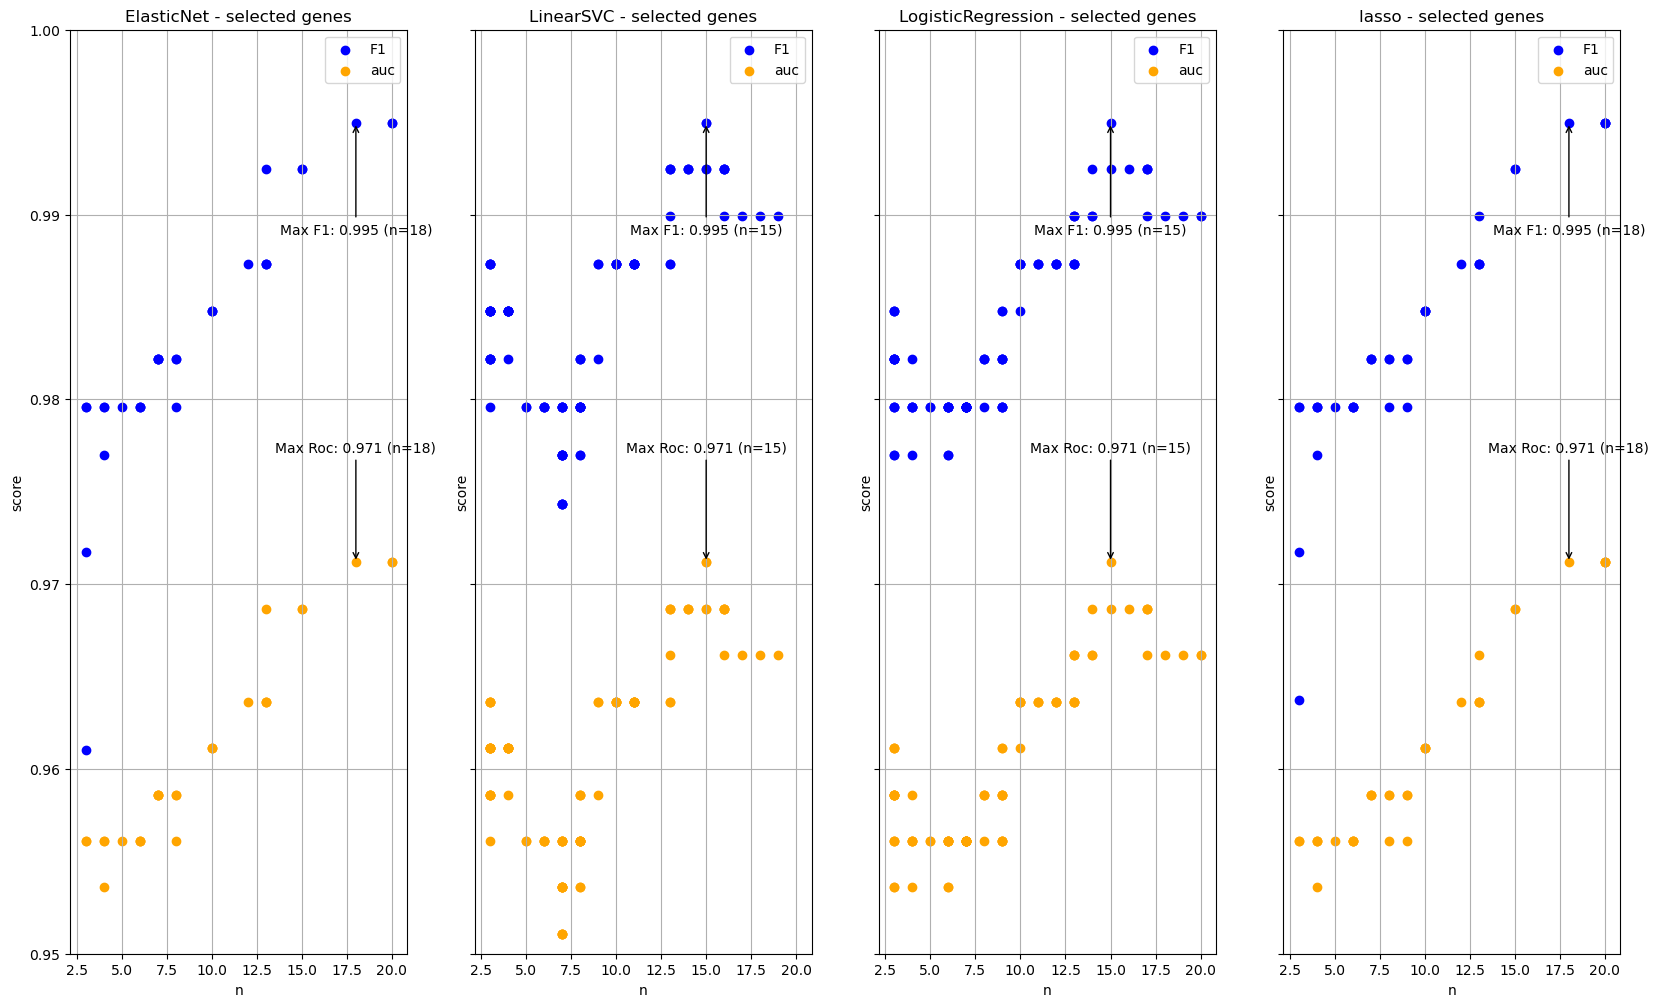

In [234]:
# for results_sorted_found_coef, draw the figure
# Group the results by method and model
# filter by n
results_sorted_found_coef_n = results_sorted_found_coef[results_sorted_found_coef['n'] <= 25]
groups = results_sorted_found_coef_n.groupby(['method'])
methods = [method for method, _ in groups]
# Create a figure with multiple subplots
fig, axs = plt.subplots(1,len(methods), sharex=True, sharey=True, figsize=(20, 12))

# Iterate over the subplots and plot the acc and roc values
for i, method in enumerate(methods):
    group = groups.get_group(method)
    axs[i].scatter(group['n'], group['f1'], label='F1', color='blue')
    axs[i].scatter(group['n'], group['auc'], label='auc', color='orange')
    axs[i].set_xlabel('n')
    axs[i].set_ylabel('score')
    axs[i].set_ylim([0.95, 1.00]) # Set y-axis limits
    axs[i].legend()
    # Find the maximum acc and roc values for this method and model
    max_acc_idx = group['f1'].idxmax()
    max_auc_idx = group['auc'].idxmax()
    max_acc = group.loc[max_acc_idx, 'f1']
    max_auc = group.loc[max_auc_idx, 'auc']
    max_n_acc = group.loc[max_acc_idx, 'n']
    max_n_auc = group.loc[max_auc_idx, 'n']

    # Add annotations with the maximum acc and roc values
    axs[i].annotate(f'Max F1: {max_acc:.3f} (n={max_n_acc})',
                        xy=(max_n_acc, max_acc),
                        xytext=(max_n_acc, max_acc - 0.006),
                        ha='center',
                        arrowprops=dict(arrowstyle='->'))
    axs[i].annotate(f'Max Roc: {max_auc:.3f} (n={max_n_auc})',
                        xy=(max_n_auc, max_auc),
                        xytext=(max_n_auc, max_auc + 0.006),
                        ha='center',
                        arrowprops=dict(arrowstyle='->'))

    axs[i].set_title(f'{method} - selected genes')
    # grid
    axs[i].grid()

# 导出保存

In [235]:
# # 计算f1值的60%分位数
# quantile_60 = results_sorted_found_coef['f1'].quantile(0.6)
# 
# # 过滤results_sorted_found_coef，只保留f1值在前60%的数据
# filtered_results = results_sorted_found_coef[results_sorted_found_coef['f1'] >= quantile_60]
# filtered_results
filtered_results = results_sorted_found_coef

In [236]:
# import excel 
import openpyxl
# 时间
import time
xsl_file = str(dataset_name) + time.strftime("%Y%m%d%H%M%S", time.localtime()) + '.xlsx'
# 检查文件是否存在
import os
if os.path.exists(xsl_file):
    os.remove(xsl_file)
wb = openpyxl.Workbook()
ws = wb.active
try:
    ws = wb['Results']
except KeyError:
    ws = wb.create_sheet('Results')
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
for col in range(len(filtered_results.columns)):
    ws.cell(row=1, column=col+1, value=filtered_results.columns[col])
# write data
for i in range(len(filtered_results)):
    for col in range(len(filtered_results.columns)):
        # not NaN
        if filtered_results.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=filtered_results.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(filtered_results.iloc[i, col]))

In [237]:
# 创建一个默认字典来存储每个列表的f1值的总和、计数、最大f1值和对应的其他值
f1_dict = defaultdict(lambda: [0, 0, 0, float('inf'), 0, 0, 0, None])

# 遍历filtered_results，更新f1_dict
for _, row in filtered_results.iterrows():
    key = tuple(row['gene_id'])
    f1_dict[key][0] += row['f1']
    f1_dict[key][1] += 1
    if row['f1'] > f1_dict[key][2] or (row['f1'] == f1_dict[key][2] and row['intercept'] < f1_dict[key][3]):
        f1_dict[key][2] = row['f1']
        f1_dict[key][3] = row['intercept']
        f1_dict[key][4] = row['coef_rounded']
        f1_dict[key][5] = row['multiple_times']
        f1_dict[key][6] = row['delta']
        f1_dict[key][7] = row['model']

# 创建一个空的DataFrame
df = pd.DataFrame(columns=['List', 'Length', 'Count', 'Average F1 Score', 'Max F1 Score','Best Coef',  'Best Intercept', 'Best Multiple Times', 'Best Delta', 'Best Model'])

# 将f1_dict的内容添加到DataFrame中
for key, value in f1_dict.items():
    df = df.append({'List': list(key), 'Length': len(key), 'Count': value[1], 'Average F1 Score': value[0] / value[1], 'Max F1 Score': value[2], 'Best Intercept': value[3], 'Best Coef': value[4], 'Best Multiple Times': value[5], 'Best Delta': value[6], 'Best Model': value[7]}, ignore_index=True)

# 按照长度和出现次数进行排序
df = df.sort_values(by=['Length', 'Count'])

In [238]:
try:
    ws = wb['Sheet1']
except KeyError:
    ws = wb.create_sheet('Sheet1')
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
for col in range(len(df.columns)):
    ws.cell(row=1, column=col+1, value=df.columns[col])
# write data
for i in range(len(df)):
    for col in range(len(df.columns)):
        # not NaN
        if df.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=df.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(df.iloc[i, col]))

In [239]:
gene_data = pd.DataFrame()
# count
miRNAs = filtered_results['gene_id'].tolist()
# 统计出现次数 miRNAs_count as a dict
miRNAs_count = {}
for miRNA in miRNAs:
    # miRNA is a list
    # Add length of miRNA to miRNA
    for miRNA_ in miRNA:
        if miRNA_ in miRNAs_count:
            miRNAs_count[miRNA_] += 1
        else:
            miRNAs_count[miRNA_] = 1

miRNAs_count = sorted(miRNAs_count.items(), key=lambda x: x[1], reverse=True)
miRNAs_count = pd.DataFrame(miRNAs_count, columns=['gene_id', 'count'])

In [240]:
try:
    ws = wb['Count']
except KeyError:
    ws = wb.create_sheet('Count')
# remove all rows
ws.delete_rows(1, ws.max_row)
# write column name
df = miRNAs_count
for col in range(len(df.columns)):
    ws.cell(row=1, column=col+1, value=df.columns[col])
# write data
for i in range(len(df)):
    for col in range(len(df.columns)):
        # not NaN
        if df.iloc[i, col] == '':
            ws.cell(row=i+2, column=col+1, value='N/A')
        else:
            try:
                ws.cell(row=i+2, column=col+1, value=df.iloc[i, col])
            except ValueError:
                ws.cell(row=i+2, column=col+1, value=str(df.iloc[i, col]))
# save
# delete default sheet
wb.remove(wb['Sheet'])

wb.save(xsl_file)

### 绘图

In [241]:
# 选择的模型
# 实际输入的模型
select = results_sorted_found_coef[results_sorted_found_coef['reproduce'] == True][results_sorted_found_coef['n'] <= 12].copy().iloc[0]
feature = select.gene_id
print('feature:', feature)
weight = select.coef_rounded
print('weight:', weight)
times = select.multiple_times
intercept = select.intercept
model = select.model

feature: ['hsa-mir-205', 'hsa-mir-192', 'hsa-mir-182', 'hsa-mir-203a', 'hsa-mir-21', 'hsa-mir-148a', 'hsa-let-7b', 'hsa-mir-101-1', 'hsa-mir-143', 'hsa-mir-30a']
weight: [1.0, 3.0, 10.0, 2.0, 1.0, 5.0, -2.0, -20.0, -1.0, -3.0]


In [242]:
ID = feature.copy()
ID.append("Status")
ID = np.array(ID).reshape(-1)
ID.astype('str')
testdata = pd.concat([X_test, y_test], axis=1)[ID]
# testdata = train_data[ID]

In [243]:
# 对平均值都乘以权重
weight = weight + [1]
testdata_weight = testdata * weight
weight = weight[:-1]
testdata_weight['score'] = testdata_weight.sum(axis=1) / times + intercept
if model == 'lr':
    testdata_weight['score'] = testdata_weight['score'].apply(lambda x: 1 / (1 + np.exp(-x)))
testdata_weight['prediction'] = testdata_weight['score'].apply(lambda x: 1 if x > 0.5 else 0)

In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scikit-learn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay
def plot_metrics(testdata_weight, feature, weight):
    # 创建一个figure并添加4个子图（ax）
    fig, axs = plt.subplots(2, 2, figsize=(12, 12))

    # 在第一个子图上绘制分数分布图
    scatter = axs[0, 0].scatter(range(len(testdata_weight['score'])), testdata_weight['score'], c=testdata_weight['Status'], cmap='bwr', alpha=0.5)
    axs[0, 0].plot([0, len(testdata_weight['score'])], [0.5, 0.5], color='black', lw=1, linestyle='--')
    axs[0, 0].set_title('Score distribution')
    legend1 = axs[0, 0].legend(['Threshold', 'Positive', 'Negative'], loc="upper right")
    axs[0, 0].add_artist(legend1)

    # 在第二个子图上绘制ROC曲线
    fpr, tpr, _ = roc_curve(testdata_weight['Status'], testdata_weight['score'])
    roc_auc = auc(fpr, tpr)
    axs[0, 1].plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.4f)' % roc_auc)
    axs[0, 1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[0, 1].set_xlim([0.0, 1.0])
    axs[0, 1].set_ylim([0.0, 1.05])
    axs[0, 1].set_xlabel('False Positive Rate')
    axs[0, 1].set_ylabel('True Positive Rate')
    axs[0, 1].set_title('Receiver operating characteristic')
    axs[0, 1].legend(loc="lower right")

    # 在第三个子图上绘制PR曲线
    precision, recall, _ = precision_recall_curve(testdata_weight['Status'], testdata_weight['score'])
    axs[1, 0].step(recall, precision,color='darkorange', lw=2, where='post')
    axs[1, 0].set_xlabel('Recall')
    axs[1, 0].set_ylabel('Precision')
    axs[1, 0].set_ylim([0.0, 1.05])
    axs[1, 0].set_xlim([0.0, 1.0])
    axs[1, 0].set_title('Precision-Recall curve')
    axs[1, 0].legend(['PR curve'])

    # 在第四个子图上绘制混淆矩阵
    cm = confusion_matrix(testdata_weight['Status'], testdata_weight['prediction'])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
    disp.plot(ax=axs[1, 1], cmap='Blues', colorbar=False)
    axs[1, 1].set_title('Confusion Matrix')

    # add margin at bottom
    fig.text(0.5, 0.04, 'feature:'+str(feature), ha='center', va='bottom', fontsize=8)     # 在图的下方加上文字，这里的0.5,0.04是指文字的位置，ha='center'是指文字居中，va='bottom'是指文字在底部，fontsize=12是指文字大小
    fig.text(0.5, 0.02, 'Weight:'+str(weight), ha='center', va='bottom', fontsize=12)          # 同上

    fig.suptitle('Metrics and Feature Weights', fontsize=16)
    plt.tight_layout()
    # 得调整图的下边距，否则会显示不全
    plt.subplots_adjust(bottom=0.1)
    plt.show()

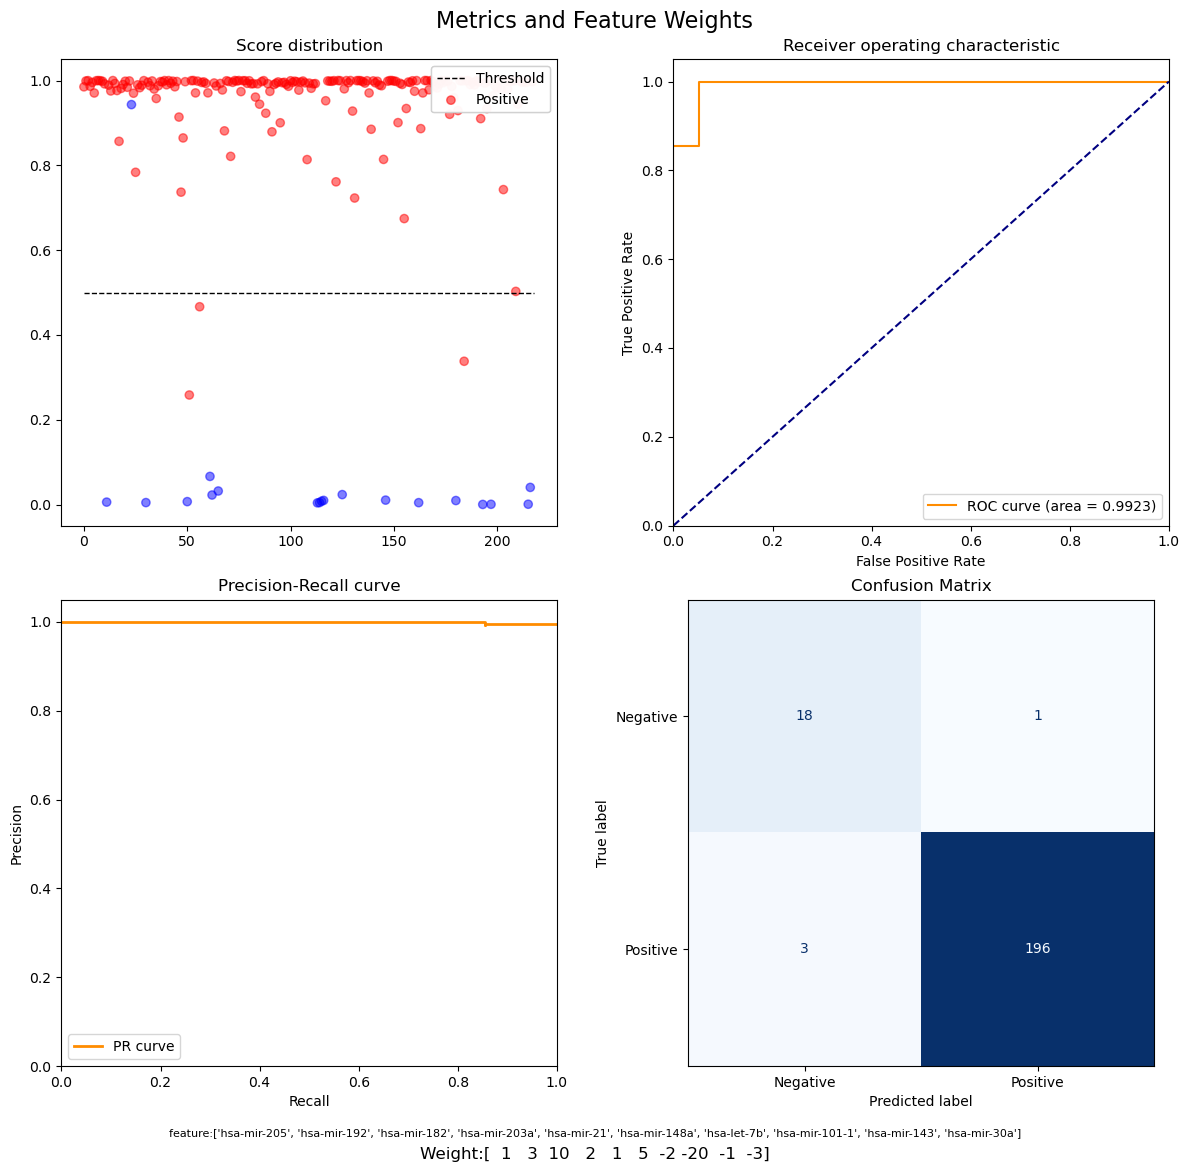

In [245]:
weight_int = np.array(weight, dtype=int)
plot_metrics(testdata_weight, feature, weight_int)